In [1]:
#Append path to Ruomin's Edamame Package (Nanowire Simulations)
import sys
sys.path.append('/import/silo2/aloe8475/Documents/edamame')

In [2]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.lines as mlines
from matplotlib import colors
import pandas as pd
import skspatial
from skspatial.objects import Plane, Points
from skspatial.plotting import plot_3d


from scipy.io import loadmat, savemat
from scipy import signal

#Import Ruomin's package
from edamame import * 


#import networkx for visualisation of networks
import networkx as nx

#tqdm allows for progress bars
from tqdm.notebook import tqdm_notebook as tqdm

import os
from IPython.core.debugger import set_trace
import matplotlib.colors as clrs


# GENERATE CSV FILE OF IMAGES:

In [4]:
"""
Created on Thu Jul  1 13:16:32 2021

@author: gnate
"""

# Define some noise functions
def zero_bit_noise(N):
    noise_list = []
    noise_vec = np.zeros((1,N))
    noise_list.append(noise_vec)
    return noise_list

def one_bit_noise(N):
    noise_list = []
    for i in range(0,N):
        noise_vec = np.zeros((1,N))
        noise_vec[0,i] = 1
        noise_list.append(noise_vec)
    return noise_list

def xor_array(x,y):
    a = x.reshape((1,9))
    b = y.reshape((1,9))
    output_vec = np.zeros((1,a.shape[1]), dtype = 'uint')
    for i in range(0, a.shape[1]):
        output_vec[0, i] = a[0, i] ^ b[0, i]
    return output_vec     

def hamming_dist(x,y):
    dist = 0
    output_vec = xor_array(x,y)
    dist = sum(output_vec.T)
    return dist

## Main program
  
#Generate 3x3 noiseless data
N = 9
orig_inputs = ['111010111', '101010010', '101111101']
orig_inputs_matrix = np.zeros((len(orig_inputs), 1, N), dtype = 'uint')
for i in range(0,len(orig_inputs)):
    input_tuple = tuple(orig_inputs[i])
    for j in range(0, N):
        if input_tuple[j] == '1': orig_inputs_matrix[i,0,j] = 1
#print('Input Matrix -', orig_inputs_matrix)
               
# Generate 5x5 noisy data
noise_vectors = []
noise_vectors.append(zero_bit_noise(N))
noise_vectors.append(one_bit_noise(N))
#print('Noise vectors - ', noise_vectors)

count_vec = np.zeros(2, dtype = 'uint')
for i in range(0,2):
    count_vec[i] = np.math.factorial(N)/(np.math.factorial(i)*np.math.factorial(N-i))

noisy_data_matrix = np.zeros((len(orig_inputs)*int(sum(count_vec)), 1, N), dtype = 'uint')
row_count = 0
for i in range(0,len(orig_inputs)):
    for j in range(0,2):
        bit_noise = np.array(noise_vectors[j], dtype = 'uint')
        for k in range(0, int(count_vec[j])):
            noisy_data_matrix[row_count] = xor_array(orig_inputs_matrix[i], bit_noise[k])
            row_count += 1
            
final_data_matrix = np.zeros((len(orig_inputs)*int(sum(count_vec)), 1, N+1), dtype = 'uint')
final_data_matrix[0:len(orig_inputs)*int(sum(count_vec)), 0, 0:N] = noisy_data_matrix.reshape(len(orig_inputs)*int(sum(count_vec)), N)

for i in range(0,len(orig_inputs)):
    final_data_matrix[int(sum(count_vec))*i: int(sum(count_vec))*(i+1), 0, N] = i
    
 
#Save data as csv file
np.savetxt("3x3image_gen.csv", final_data_matrix.reshape(len(orig_inputs)*int(sum(count_vec)), N+1), delimiter=",")
    
print('Saved')

Saved


# RUN LINEAR CLASSIFICATION

Created on Thu May 27 00:36:08 2021

@author: gnate

### TARGETS: 0 - 'z', 1 - 'v', 2 - 'n'

X = 9x30, y = 1x30

In [5]:
#Functions

# Define function to generate one-hot encoding
def create_target(t):
    target_vector=np.zeros([t.shape[0],3])
    for row in range(t.shape[0]):
        target_vector[row,:] = np.zeros(3)
        for i in range(3):
            if i == t[row]:
                   target_vector[row,i] = 1    
    return target_vector

def create_single_target(t):
        target_vector = np.zeros(3)
        for i in range(3):
            if i == t:
                target_vector[i] = 1
        return target_vector
    
# Define angle function for rotating plot gif    
# def rotate(angle):
#        ax.view_init(azim=angle)

In [6]:
# Load 3x3 dataset
letters = pd.read_csv("./3x3image_gen.csv", sep=',', header = None)
data = letters.values[:, 0:9]

sample_num = 30      # Number of data samples

# Target labels: 0 - 'z', 1 - 'v', 2 - 'n'
targets = letters.values[:, 9]
inputs = np.zeros((sample_num,10))
inputs[:,0:9] = data
inputs[:,9] = np.ones(sample_num)   #Bias input

# Standardize data - Uncomment to standardize data, not necessary
# inputs = data - np.mean(data)
# inputs = inputs/(np.std(data))

In [7]:
target_letters=['z','v','n']
# target_letters=['x','o']

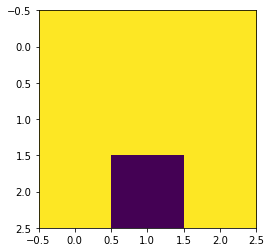

In [8]:
# View data sample as 3x3 image
%matplotlib inline
# rnd = np.random.randint(0, 30)
image_example = data[22].reshape(3,3)
plt.imshow(image_example,aspect='1')

In [9]:
plt.imshow(letters.values[rnd][:-1].reshape(3,3)) 
print('Target Letter: ' + target_letters[int(letters.values[rnd][-1])])

NameError: name 'rnd' is not defined

In [10]:
# One-hot encoding of outputs
onehot_outputs = create_target(targets) #1 0 0 = z, 0 1 0 = v, 0 0 1 = n

# Generate inverse of input matrix
inv_inputs = np.linalg.pinv(inputs)

# Linear solve for inputs * W = onehot_outputs
W = np.zeros((10,3))
W = np.matmul(inv_inputs, onehot_outputs)
print("Weight matrix from linear solve - \n", W[:9,:])
print("Biases of output nodes - \n", W[9,:])

# Generate scatter plot of predicted outputs from linear solve 
predicted_outputs = np.matmul(inputs, W)
#print("\n Output predictions using linear solve - \n", predicted_outputs)

# Calculate prediction accuracy
accuracy = 0
for i in range(0,sample_num):
    if np.argmax(predicted_outputs[i]) == targets[i]:
        accuracy = accuracy + 1
print('Prediction accuracy -', accuracy/sample_num)

Weight matrix from linear solve - 
 [[ 0.0331142  -0.00779158 -0.02532262]
 [ 0.43438033 -0.25906988 -0.17531045]
 [ 0.0331142  -0.00779158 -0.02532262]
 [-0.19478938 -0.11102995  0.30581933]
 [ 0.0331142  -0.00779158 -0.02532262]
 [-0.19478938 -0.11102995  0.30581933]
 [ 0.27270514 -0.3778914   0.10518627]
 [ 0.19478938  0.11102995 -0.30581933]
 [ 0.27270514 -0.3778914   0.10518627]]
Biases of output nodes - 
 [-0.24129535  0.93912832  0.30216703]
Prediction accuracy - 1.0


<IPython.core.display.Javascript object>


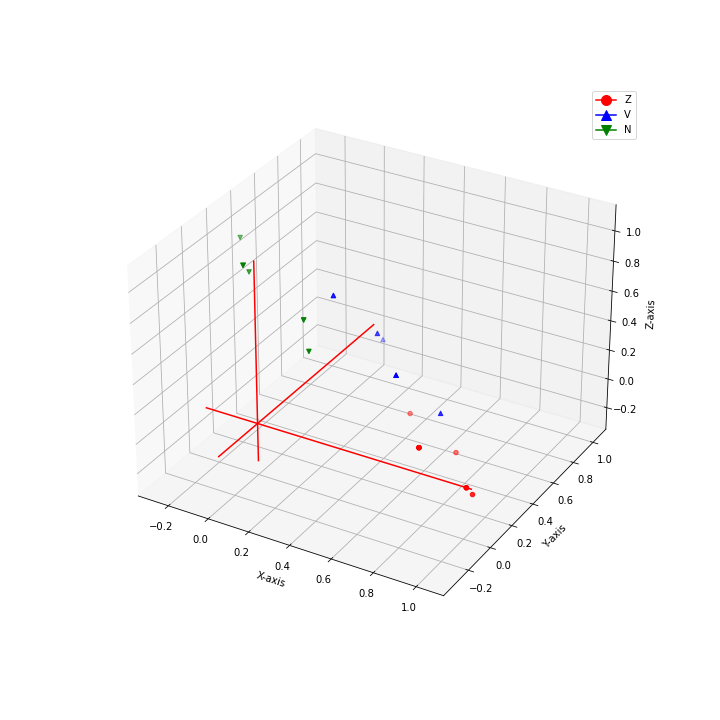

In [11]:
# Plot figures 
%matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for c, m, low, high in [('r', 'o', 0, 10), ('b', '^', 10, 20), ('g', 'v', 20, sample_num)]:
    xdata = predicted_outputs[low:high,0]
    ydata = predicted_outputs[low:high,1]
    zdata = predicted_outputs[low:high,2]
    ax.scatter(xdata, ydata, zdata, c = c, marker = m);
    
# Make simple, bare axis lines through space:
xAxisLine = ((min(predicted_outputs[:,0]), max(predicted_outputs[:,0])), (0, 0), (0,0))
ax.plot(xAxisLine[0], xAxisLine[1], xAxisLine[2], 'r')
yAxisLine = ((0, 0), (min(predicted_outputs[:,1]), max(predicted_outputs[:,1])), (0,0))
ax.plot(yAxisLine[0], yAxisLine[1], yAxisLine[2], 'r')
zAxisLine = ((0, 0), (0,0), (min(predicted_outputs[:,2]), max(predicted_outputs[:,2])))
ax.plot(zAxisLine[0], zAxisLine[1], zAxisLine[2], 'r')

# Set axes labels and figure legend
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')

red_point =  mlines.Line2D([], [], color='red', marker='o', 
                          markersize=10, label='Z')
blue_point = mlines.Line2D([], [], color='blue', marker='^', 
                           markersize=10, label='V')
green_point = mlines.Line2D([], [], color='green', marker='v', 
                           markersize=10, label='N')
plt.legend(handles=[red_point, blue_point, green_point])

plt.show()

# Generate rotating gif - Uncomment to generate the gif in current dir
# angle = 3
# ani = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360, angle), interval=20)
# ani.save('predicted_outputs.gif', writer=animation.PillowWriter(fps=10))

# Test with some input
#rnd = np.random.randint(0,29)
#print("Predicted output -", test_output)
#actual_output = create_single_target(targets[rnd])
#print("Actual output -", actual_output)

# Repeat with Nanowire Network:

### Set up network 

In [12]:
#Generating Electrode positions in Network - Written by Ruomin Zhu
def genGridNW(xa,xb,ya,yb,ex,ey):
    e = []
    for i in range(len(ex)):
        d = np.zeros(len(xa))
        for j in range(len(xa)):
            d[j]=dist((xa[j], ya[j]), (xb[j], yb[j]), (ex[i], ey[i]))
        e.append(np.argmin(d))
    return np.array(e)

def point_on_line(a, b, p):
    ap = p - a
    ab = b - a
    result = a + np.dot(ap, ab) / np.dot(ab, ab) * ab
    return result

def dist(p1,p2,p3):
    p1=np.array(p1) #xa ya
    p2=np.array(p2) #xb yb
    p3=np.array(p3) # ex ey (electrode placement)
    
    #determine whether closest point to electrode is on the line, or outside the line 
    t=point_on_line(p1,p2,p3)
    if t[1]<p1[1]:
        r = np.linalg.norm(p3-p1) #if point is outside left (xvalues)
    elif t[1] > p2[1]:
        r = np.linalg.norm(p3-p2) #if point is outside right (xvalues)
    else:
        r = np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1) #if point is inside xvalues
    return r

In [13]:
#load SPARSE network
#Not you need this file in a folder called Sparse Networks 
# asn_nw_00300_nj_00621_seed_1252_avl_10.00_disp_01.00_lx_100.00_ly_100.00
#
nw=loadmat('../Sparse Networks/asn_nw_00250_nj_00794_seed_134_avl_10.00_disp_01.00_lx_50.00_ly_50.00')
this_seed=8639#np.random.randint(10000) #random seed
Network=nw#edamame.core.generate_network(300,dispersion=350,mean_length=200,this_seed=this_seed)
connectivity=connectivity__(wires_dict=Network) 

In [14]:
#fixing file structure from Matlab:
connectivity.avg_length=connectivity.avg_length[0][0]
connectivity.number_of_junctions=connectivity.number_of_junctions[0][0]
connectivity.centroid_dispersion=connectivity.centroid_dispersion[0][0]
connectivity.dispersion=connectivity.dispersion[0][0]
# connectivity.generating_number_of_wires=connectivity.generating_number_of_wires[0][0]
connectivity.gennorm_shape=connectivity.gennorm_shape[0][0]
connectivity.length_x=connectivity.length_x[0][0]
connectivity.length_y=connectivity.length_y[0][0]
connectivity.number_of_wires=connectivity.number_of_wires[0][0]
connectivity.numOfWires=connectivity.numOfWires[0][0]
connectivity.numOfJunctions=connectivity.numOfJunctions[0][0]
connectivity.theta=connectivity.theta[0][0]
connectivity.this_seed=connectivity.this_seed[0][0]

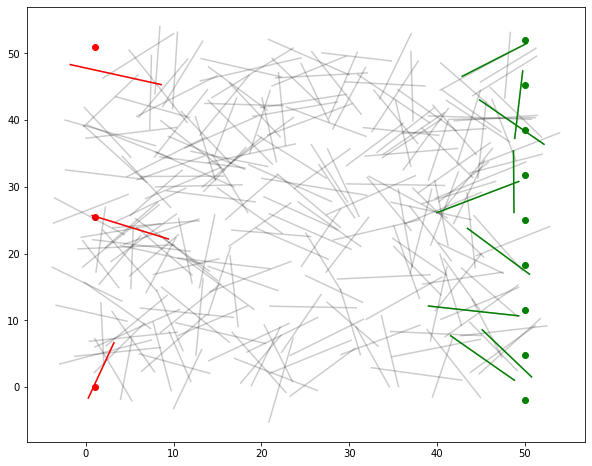

In [15]:
#Generate Network
%matplotlib inline

#find x and y values of each end of each wire 
xa=connectivity.xa[0]
xb=connectivity.xb[0]
ya=connectivity.ya[0]
yb=connectivity.yb[0]

#Pick Electrode placement/distance apart:

#DRAINS
numDrains=3
ex=np.ones(numDrains)*1#*15
# ey=np.linspace(0,550,numDrains)
ey=np.linspace(0,51,numDrains)#(50,100,numDrains)

elecDrain=genGridNW(xa,xb,ya,yb,ex,ey) #generate drain locations in ex, ey coordinates

plt.figure(figsize=(10,8))
plt.scatter(ex, ey, c = 'r')

#SOURCES
numSources=9
ex=np.ones(numSources)*50#95
# ey=np.linspace(0,550,numSources)
ey=np.linspace(-2,52,numSources)#(35,100,numSources)

elecSource=genGridNW(xa,xb,ya,yb,ex,ey) #generate source locations in ex, ey coordinates

plt.plot([xa, xb], [ya, yb], c = 'k',alpha=0.2)
plt.plot([xa[elecDrain], xb[elecDrain]], [ya[elecDrain], yb[elecDrain]], c = 'r')
plt.plot([xa[elecSource], xb[elecSource]], [ya[elecSource], yb[elecSource]], c = 'g')

plt.scatter(ex, ey, c = 'g')

# plt.savefig(figLoc+'Network and Electrodes.png',dpi=300)

### Define Functions

In [16]:
# #This function is the initial network activation (similar to letting it run to equilibrium)
# #Here, we open all the target drains and close all the non-target drains, and let the network do its thing without any 
# #training or drain tuning.

# def init(sources,onAmp_init,init_runTime,currInput,signalType='DC'):
#     #Initialise stimulus:
    
#     init_stimulus = []
    
#     #Drains: 
#     for i in range(num_drain_init): #for each drain, assign stimulus input of 0V 
#         init_stimulus.append((stimulus__(biasType='Drain',T=init_runTime,dt=dt)))

#     #Sources
#     for i in range(num_source_init):
#         if currInput[i]==1:
#             init_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp_init,T=init_runTime,dt=dt)))
#         else:
#             init_stimulus.append((stimulus__(biasType=signalType,onAmp=0,T=init_runTime,dt=dt)))

#     return init_stimulus

In [17]:
# #This function runs the init simulation and saves the network state at the end.
# def getInitState(init_stimulus,sources,drain_pool,target_index,count):
#     eles = np.append(drain_pool[target_index], sources) #define all electrodes (only drains in target_index)
# #     if count == 1 or count ==11 or count == 21:
# #         set_trace()
#     if len(eles) == num_drain_init + num_source_init: #make sure right number of electrodes otherwise won't work
#         init_sim = runSim(connectivity, stimulus = init_stimulus,
#                            junctionMode = 'tunneling',
#                            dt = dt, T = run_time, 
#                            contactMode = 'preSet',
#                            electrodes = eles,
#                            findFirst = False,disable_tqdm=True,
#                            criticalFlux=0.01)

#         JS0 = getJunctionState(init_sim, -1) #save network state at last timestep
#     else: 
#         print('Bless you Joel :)')
        
#     return init_sim,JS0

In [18]:
#This function sets up the stimuli for simulations. 
def setupStimulus(training_stimulus,currInput,onAmp_training=1,signalType='DC'):

    for i in range(num_drain_training):
        training_stimulus.append((stimulus__(biasType='Drain',T=run_time,dt=dt)))
        
    #Sources
    for i in range(len(currInput)):
        if currInput[i]==1:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp_training,T=run_time,dt=dt)))
        else:
            training_stimulus.append((stimulus__(biasType=signalType,onAmp=0,T=run_time,dt=dt)))

    return training_stimulus

In [19]:
#This function runs each training epoch and saves the network state at the last timestep of that epoch

def getNWState(training_stimulus,state,drain_pool,sources,run_time=2):
    eles = np.append(drain_pool, sources) #all drains
    if len(eles) == num_drain_training + num_source_training:
        training_sim = runSim(connectivity, stimulus = training_stimulus,
                           junctionMode = 'tunneling',
                           dt = dt, T = run_time, 
                           contactMode = 'preSet',
                           electrodes = eles,
                           findFirst = False,
                           start_state = state,
                           disable_tqdm=True)
                           #criticalFlux=0.01)  
        JS1 = getJunctionState(training_sim, -1) #save state
    else: 
        print('Bless you Joel :)')
    return training_sim,JS1

In [20]:
#This function sets up the stimuli for the testing part of the simulation. 
def setupSourcesOnly(stimulus,currInput,onAmp=1,signalType='DC'):
    #Sources
    for i in range(len(currInput)):
        if currInput[i]==1:
            stimulus.append((stimulus__(biasType=signalType,onAmp=onAmp,T=run_time,dt=dt)))
        else:
            stimulus.append((stimulus__(biasType=signalType,onAmp=0,T=run_time,dt=dt)))
    return stimulus

In [21]:
#This function calculates the conductance read out at each drain electrode, 
#which we use to determine if the target threshold for each electrode is met

def calcOutputs(sim2, sources,all_drains):
    
    cc = np.zeros(len(all_drains))
    resist = np.zeros(len(all_drains))

#     for i, d in enumerate(all_drains):
#         a = wireCurrentTimeSeries(sim1, d)
#         b = wireCurrentTimeSeries(sim2, d)
#         print(a.shape,b.shape)
#         cc[i] = np.dot(a.reshape(-1),b.reshape(-1))

#     cc=(cc-minval)/(maxval-minval)
#       return cc

# ALTERNATIVE METHOD SUGGESTED BY JOEL


#Index network state:
    #IF PULSE - we want the state of the network at the end of the last pulse 
    if sim2.stimulus[-1].biasType=='Pulse':
        t=sim2.stimulus[-1].signal>0.005
        idx=[i for i, x in enumerate(t) if x][-1]
    else: #otherwise we take 4 timesteps as the state of the network 
#         idx=[500,1000,1500,-1]
        idx=-1
        
        
#Calculate Current at network state: 
    for i, d in enumerate(all_drains): #for each drain electrode
        #current
        cc[i]=sim2.electrodeCurrent.T[i][idx]#/(sim2.wireVoltage.T[sources[0]][idx]-sim2.wireVoltage.T[d][idx])
        #resistance
        resist[i]=sim2.wireVoltage.T[d][idx]/sim2.electrodeCurrent.T[i][idx]
        
        # Conductance = Current Drain / (Voltage Source - Voltage Drain)
    return cc,resist


In [22]:
#Calculate cost function
def calc_cost(x,y):
    return (1/2)*((x-y)**2)

In [67]:
#This function changes the write voltage of the drain electrodes. This is where we tune the system so that 
#it prioritises/de-prioritises certain pathways based on targets and non-targets
def change_voltage(stimulus,sim2,outputVals,resistVals,target_index,th=0,th2=0,signalType='DC'):
    import math
    Vi        = np.zeros((2000))
    n         = len(outputVals)
    cost      = np.zeros(n)
    beta      = 0.05 #change the values here
    grad      = np.zeros((n))
    
    for i in range(n): # for each drain:
        stop  = False
        stop2 = False
        
        if i == target_index: #if it is a target drain: 
            if outputVals[i] > (th - 0.1) and outputVals[i] < th: #if we're in the range of 0.8 to 1
                stop    = True
                
            currentVal=outputVals[i]
            
            #calculate cost
            cost[i]     = calc_cost(currentVal,th)
            #calculate gradient
            if stop == False:
                grad[i] = beta*(currentVal-th) 
            else:
                grad[i] = 0
                
            #change voltage    
            stimulus[i].signal += Vi+grad[i] #change voltage using gradient 
        
        else: #if it is a non-target drain:
            
            #if we're in the range of 0 to 0.2
            if outputVals[i] < (th2 + 0.1) and outputVals[i] > th2:
                stop2   = True
                
            currentVal=outputVals[i]
            
            #calculate cost
            cost[i]     = calc_cost(currentVal,th2)
            #calculate gradient
            if stop2 == False:
                grad[i] = beta*(currentVal-th2)
            else:
                grad[i] = 0
                
            #change voltage    
            stimulus[i].signal += Vi+grad[i]
            
            #diff between target and output
            
    print('Normalized Currents '+str(outputVals))
    print('Cost '+str(np.sum(cost)))
    print('Gradients '+str(grad))
    return outputVals,stimulus,cost

In [68]:
#This function combines all the training functions into one step:

def runSimulations(stimulus,state,signalType,run_time=2):
    #first we run the training for this epoch, and get the network state at the last timestep:
    simulation,new_state = getNWState(stimulus,state,drain_pool,sources,run_time=2) 
    #we then calculate the drain currents at that network state
    t,r      = calcOutputs(simulation,sources,drain_pool)
    return t,r,new_state,simulation

#This is how we test new inputs - only care about cost
def runTesting(outputVals,th,th2):
    n     = len(outputVals)
    cost  = np.zeros(n)
    for i in range(n): # for each drain:
        currentVal=outputVals[i]
        if i == target_index: #if it is a target drain: 
            cost[i] = calc_cost(currentVal,th) #calculate cost\
        else:
            cost[i] = calc_cost(currentVal,th2)
    return cost


## Training

In [69]:
sources = elecSource
drain_pool = elecDrain
allTargets=onehot_outputs

In [70]:
#Split into Training and Testing:
targetClass     = 1 #'v'
targetClassVals=[0,1,2]
trainingInputs  = inputs[targets==targetClass][:-2] #training set
testingInputs   = inputs[targets==targetClass][-2:] #test set

In [72]:
#Global Variables
outputs              = {'cost':[],'current':[],'normcurrent':[],'randseed':[],'state':[],'target':[]}
numSamples           = 10 #number of random samples from same class
seed                 = 42 #random seed
epochs               = 50 #number of 'training' to run max, unless we hit 0.1 first
thisNwState          = None #inital network state
network_state        = [[[] for i in range(epochs)] for i in range(numSamples)]
avg_filament_state   = [[[] for i in range(epochs)] for i in range(numSamples)]
np.random.seed(seed)
minCurrent           = 1e-7
maxCurrent           = 1e-4
onAmp                = 0.5 #amplitude for init
run_time             = 2 # time for each iteration
dt                   = 0.001 #timesteps
signalType           ='DC' #Pulse, DC, AC, Square, Sawtooth
numtraining          = 1 #number of training iterations per epoch
num_drain_training   = 3 #total number of drain electrodes
num_source_training  = len(sources) #total number of source electrodes

#Run Free Phase:
print('---------- ')
print('Running Free Phase')
print('---------- ')
init_stimulus          = setupStimulus([], trainingInputs[0][:-1],onAmp,signalType) #reset stimulus each epoch
initI,initR,initNwState,initSim = runSimulations(init_stimulus,None,signalType,run_time=5)

#Run Weakly Clamped Phase
for sample in tqdm(range(numSamples)): #run 100 random samples from the same class in random order
    
    target_index = int(targetClassVals[targetClass]) #set target class
    #note - for this testing, I just use the same training sample over and over to make sure the network states are being saved
    val          = 1#np.random.randint(len(trainingInputs)) #choose a random training sample
    currInput    = trainingInputs[val][:-1] #define the input of that training sample
    
    print('---------- ')
    print('Running Weakly Clamped Phase')
    print('---------- ')
    print('Training #'+str(sample+1))
    print('Training Sample Chosen: '+str(val))
    print('Class ' +str(target_letters[target_index]))
    
#     if sample == 0: #initalise drain stimulus only for first run, after that we use the stimulus from previous samples
    training_stimulus      = []
    sim_stimulus          = setupStimulus(training_stimulus,currInput,onAmp,signalType) #reset stimulus each sample
#         Vinit    = sim_stimulus[:3] #save Vd[0] 
#     else:
#         Vd                     = newStimulus[:3] #save previous drains
#         sim_stimulus          = setupSourcesOnly(Vd,currInput,onAmp,signalType) #setup new sources
    
    print('Drain Voltages '+str([sim_stimulus[0].signal[0],sim_stimulus[1].signal[0],sim_stimulus[2].signal[0]]))
    print('Source Voltages '+str(currInput))
    print('---------- ')


    drainI        = np.zeros((epochs,num_drain_training))
    t             = np.zeros((epochs,num_drain_training))
    cost          = np.zeros((epochs,num_drain_training)) 
    
    for i in range(epochs): #for each epoch

        print('Epoch ' + str(i))
        if sample == 0 and i == 0: #if we start the first sample and first epoch
            lastNwState=initNwState
#             thisNwState=None
        elif sample >= 0 and i > 0: #if we move to a new epoch in the current sample
            lastNwState = network_state[sample][i-1] #previous state from previous epoch    
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')
        elif sample > 0 and i==0: #if we move to a new sample that isn't the first sample
            temp=[j for j in network_state[sample-1] if j][-1] #last non empty value in list
            lastNwState = temp #previous state from previous sample        
            if lastNwState!=thisNwState:
                print('nw states are not saving properly')

    
        #run simulation, save currents, resistances, network state and simulation settings
        t[i],r,thisNwState,simulation = runSimulations(sim_stimulus,lastNwState,signalType,run_time=run_time)
        
        avg_filament_state[sample][i]=np.mean(abs(simulation.filamentState),axis=1) #save filament growth
        network_state[sample][i]=thisNwState #save this network state

        
        print('Currents '+str(t[i]))
        #normalise currents:
        normT = (t[i]-minCurrent)/(maxCurrent-minCurrent)#(t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
        if i ==0:
            #normalise thresholds:
            th  = 1 #target threshold range + 0.2
            th2 = 0 #non-target threshold range + 0.2
            
        #change the voltages of target and non-target drains to tune the network into using different pathways
        drainI[i,:],newStimulus,cost[i,:] = change_voltage(sim_stimulus,simulation,normT,r,target_index,th,th2,signalType)
        print('New Drain Voltages '+str([sim_stimulus[0].signal[0],sim_stimulus[1].signal[0],sim_stimulus[2].signal[0]]))
        
        #if total cost is less than 0.02, end epochs for training sample
        thisCostSum = np.sum(cost[i,:])
        if thisCostSum < 0.02:
            print('minima found for current sample')
            outputs['current'].append(t)
            outputs['normcurrent'].append(drainI)
            outputs['cost'].append(cost)
            outputs['target'].append(target_index)
            outputs['state'].append(network_state[sample])
            outputs['randseed']=seed
            break;
            
    outputs['current'].append(t)
    outputs['normcurrent'].append(drainI)
    outputs['cost'].append(cost)
    outputs['target'].append(target_index)
    outputs['state'].append(network_state[sample])
    outputs['randseed']=seed
#     count+=1

    #if total cost is less than 0.02, end training samples
#     if thisCostSum < 0.02:
#         print('Global Minima Found')

#         break;

---------- 
Running Free Phase
---------- 


---------- 
Running Weakly Clamped Phase
---------- 
Training #1
Training Sample Chosen: 1
Class v
Drain Voltages [0.0, 0.0, 0.0]
Source Voltages [0. 0. 1. 0. 1. 0. 0. 1. 0.]
---------- 
Epoch 0
Currents [4.60261820e-08 2.04001002e-08 2.90643429e-08]
Normalized Currents [0.00054028 0.0007968  0.00071007]
Cost 0.49920391969522393
Gradients [ 0.         -0.04996016  0.        ]
New Drain Voltages [0.0, -0.04996016021028671, 0.0]
Epoch 1
Currents [2.55075223e-06 9.76717533e-07 6.56360036e-08]
Normalized Currents [0.02453205 0.00877595 0.00034398]
Cost 0.4915635273843944
Gradients [ 0.        -0.0495612  0.       ]
New Drain Voltages [0.0, -0.09952136264605815, 0.0]
Epoch 2
Currents [9.01150167e-07 5.49711561e-06 4.23386661e-06]
Normalized Currents [0.00801952 0.05402518 0.04138005]
Cost 0.4483224892989713
Gradients [ 0.         -0.04729874  0.        ]
New Drain Voltages [0.0, -0.14682010358223802, 0.0]
Epoch 3
Currents [-3.29867460e-07  7.95897910e-06  4.25391326e-06]
Normalized Currents

KeyboardInterrupt: 

In [61]:
mfs=[]
mcon=[]
for i in range(8):
    mfs.append(np.mean(network_state[i][0].filamentState))
    mcon.append(np.mean(network_state[i][0].conductance))

AttributeError: 'list' object has no attribute 'filamentState'

ValueError: x and y must have same first dimension, but have shapes (2000,) and (0,)

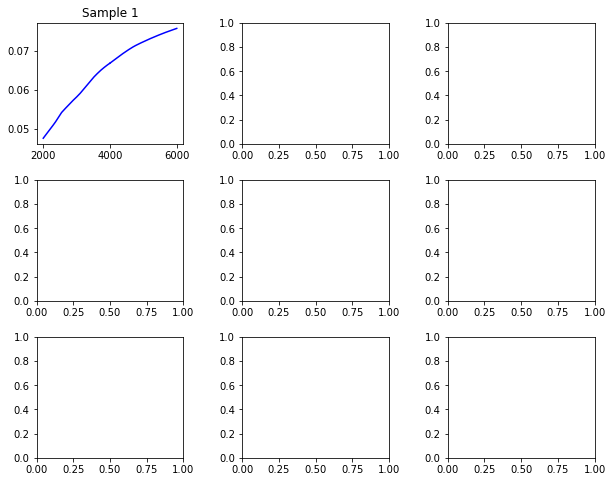

In [65]:
f,axes=plt.subplots(3,3,figsize=(10,8))
f.subplots_adjust(hspace=0.3,wspace=0.4)
i=0
for ax in axes.flat:
    ax.plot(range(2000,4000),avg_filament_state[i][0],'b')
    ax.plot(range(4000,6000),avg_filament_state[i][1],'b')
    if i >0:
        ax.plot(range(0,2000),avg_filament_state[i-1][-1],'r')
#     ax.set_ylim([-0.])
    ax.set_title('Sample '+ str(i+1))
    i+=1

In [47]:
#Collate outputs

costs=[];finalCosts=[];
currents=[];finalCurrents=[];normCurrents=[];finalNormCurrents=[]
for i in range(len(outputs['cost'])):
    costs.append(outputs['cost'][i])
    a=np.sum(costs[i],axis=1)!=0
    finalCosts.append(costs[i][np.argwhere(a==True)[-1][0]])
    currents.append(outputs['current'][i])
    a2=np.sum(currents[i],axis=1)!=0
    finalCurrents.append(currents[i][np.argwhere(a2==True)[-1][0]])
    normCurrents.append(outputs['normcurrent'][i])
    a3=np.sum(normCurrents[i],axis=1)!=0
    finalNormCurrents.append(normCurrents[i][np.argwhere(a3==True)[-1][0]])

Text(0.5, 0, 'z | v | n')

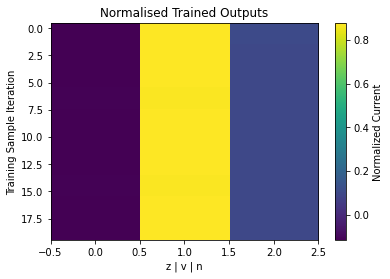

In [48]:
#visualise change in normalised currents across the drains
plt.imshow(finalNormCurrents,aspect='auto')
plt.colorbar(label='Normalized Current')
plt.title('Normalised Trained Outputs')
plt.ylabel('Training Sample Iteration')
plt.xlabel('z | v | n')

Text(0.5, 0, 'z | v | n')

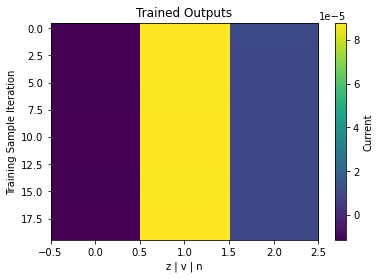

In [49]:
#visualise change in actual currents across the drains as a function of training samples

plt.imshow(finalCurrents,aspect='auto')
plt.colorbar(label='Current')
plt.title('Trained Outputs')
plt.ylabel('Training Sample Iteration')
plt.xlabel('z | v | n')

In [50]:
data=pd.DataFrame(np.array([finalCosts,finalCurrents,outputs['target']]).T)

In [51]:
maxCurrentsIdx=[]
for i in range(len(data[1])):
    maxCurrentsIdx.append(np.argmax(data[1][i]))

In [52]:
#VISUALISE NETWORK STATE
def getWeightedGraph(edgeList,numWires,nwState):#, this_TimeStamp = 0):
#     edgeList = network['edge_list']
    adjMat = np.zeros((numWires, numWires))
#     set_trace()
    adjMat[edgeList[:,0], edgeList[:,1]] = nwState.voltage*nwState.conductance#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    adjMat[edgeList[:,1], edgeList[:,0]] = nwState.voltage*nwState.conductance#network.junctionSwitch[this_TimeStamp,:] #CHANGE THIS TO CONDUCTANCE THRESHOLD?
    WeightedGraph = nx.from_numpy_array(adjMat)
    WeightedGraph=nx.DiGraph.to_undirected(WeightedGraph)
    
    return WeightedGraph

def draw_network_state(connectivity,nwState):
    adjMat=connectivity.adj_matrix
    graph=nx.from_numpy_array(adjMat)
    OGgraph=graph.copy()
    pos=nx.kamada_kawai_layout(OGgraph)
    numWires=graph.number_of_nodes()
    edgeList=np.array(list(graph.edges()))
    weightedSubGraph=getWeightedGraph(edgeList,numWires,nwState)
    minWeights=1e-7 #currents
    maxWeights=1e-4 #currents
    
    #draw network
    %matplotlib inline
    f,ax=plt.subplots(figsize=(10,6))
    G=weightedSubGraph
    edge_weights=nx.get_edge_attributes(G,'weight')
#     G.remove_edges_from((e for e, w in edge_weights.items() if w <1e-5)) 
    edges=G.edges()
    weights=[G[u][v]['weight'] for u,v in edges]

    #draw OG graph
    pos=nx.kamada_kawai_layout(OGgraph)
    h=nx.draw_networkx_nodes(OGgraph,pos=pos,node_color='grey',node_size=10,ax=ax)
    h.set_zorder(1)

    h2=nx.draw_networkx_edges(G,pos=pos,ax=ax,edge_color=weights,edge_cmap=plt.cm.hot_r,edge_vmin=minWeights,edge_vmax=maxWeights)
#     if h2:
#         h2.set_norm(clrs.SymLogNorm(10))
#         h2.set_zorder(3)
    #             if j == 10 and i == 6:
    #                 plt.colorbar(h2)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=sources,node_color='#3f9b0b',node_size=120,node_shape ='*',ax=ax)
    nx.draw_networkx_nodes(G,pos=pos,nodelist=drain_pool,node_color='r',node_size=120,node_shape ='*',ax=ax)
    plt.colorbar(h2,label='current',ax=ax)
    plt.show()

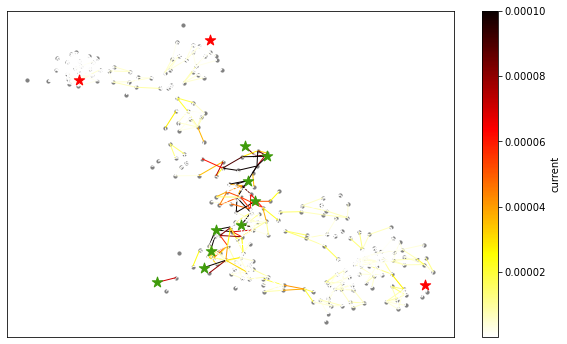

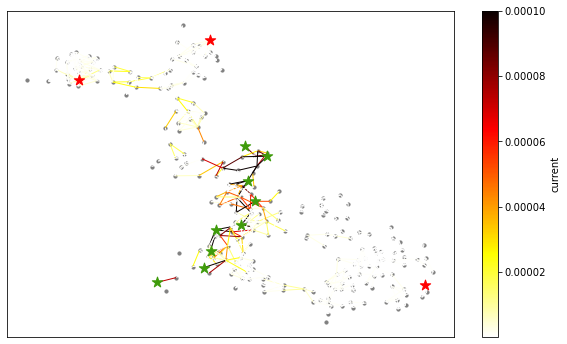

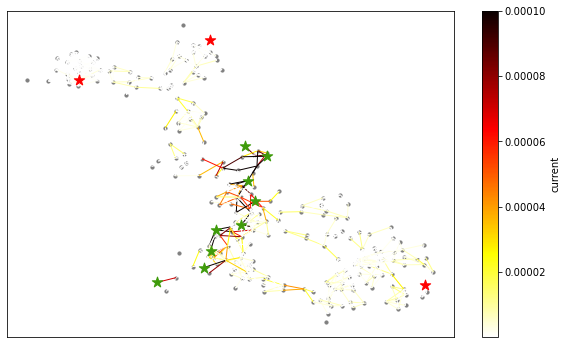

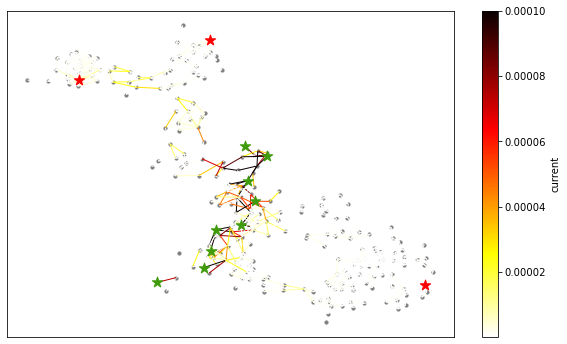

In [59]:
draw_network_state(connectivity,network_state[0][0])
draw_network_state(connectivity,network_state[0][31])
draw_network_state(connectivity,network_state[-1][0])
draw_network_state(connectivity,network_state[-1][31])

## Testing

In [723]:
# RUN TESTING WITH NEW DATA:

#Global Variables
numClasses          = 3
numTestingSamples   = len(testingInputs)
seed                = 42 #random seed
thisNwState         = None #inital network state
np.random.seed(seed)
network_state_train = [i for i in network_state[-1] if i][-1] #last network state after training
network_state_test  = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
filament_state_test = [[[] for i in range(numTestingSamples)] for i in range(numClasses)]
cost                = [[] for i in range(numClasses)]
#KEEP DRAIN VOLTAGES
drain_voltages      = False

for inputClass in tqdm(range(numClasses)): #for each class, z, v, n 
    for sample in (range(numTestingSamples)): #for each test sample
        target_index = int(targets[targets==targetClass][sample]) #set target index
        if inputClass == targetClass: #if the class we're inputting is the target class
            currTest     =  testingInputs[sample][:-1] #choose test sample inputs for desired class
        else:
            currTest     =  inputs[targets==inputClass][sample][:-1] #choose test sample inputs for other classes       

        print('---------- ')
        print('Class ' +str(target_letters[inputClass]))
        print('Test Sample ' +str(sample+1))

        print('Source Voltages '+str(currTest))


        epochs       = 1 #number of 'test' to run max, unless we hit 0.1 first
        onAmp        = 1 #amplitude for init
        run_time     = 2 # time for each iteration
        dt           = 0.001 #timesteps

        signalType   ='DC' #Pulse, DC, AC, Square, Sawtooth

        numtesting             = 1 #number of training iterations per epoch
        num_drain_testing      = 3 #total number of drain electrodes
        num_source_testing     = len(sources) #total number of source electrodes
        ttest                  = np.zeros((epochs,num_drain_testing))
        testing_stimulus       = []
        
        if drain_voltages: #if we keep drain_voltages from last training epoch
            testing_drain_stimulus = sim2_stimulus[:3]
            testing_stimulus       = setupSourcesOnly(testing_drain_stimulus,currTest,onAmp)
            
        else: #if we reset drain voltages to 0, and just use network state in runSimulations
            testing_stimulus       = setupStimulus(testing_stimulus,currTest,onAmp,signalType)

        for i in range(epochs): #for each epoch

            thisNwState = network_state_train #final state from training

            #run training + change voltages - save network state after each epoch.
            ttest[i],r,network_state_test[inputClass][sample],simtest = runSimulations(testing_stimulus,thisNwState,signalType)
            
            filament_state_test[inputClass][sample]=np.mean(simtest.filamentState,axis=1) #save filament growth
            print('Currents '+str(ttest[i]))
            print('Voltages '+str(simtest.wireVoltage.T[drain_pool].T[0]))

            #normalise currents:
            normCurr = (ttest[i]-np.min(ttest[i]))/(np.max(ttest[i])-np.min(ttest[i]))#np.mean(t[i]))/np.std(t[i])
            print('Normalized Currents '+str(normCurr))

            if i ==0:
                #normalise thresholds:
                th  =  1 #target threshold range +-0.1
                th2 = 0 #non-target threshold range +- 0.1

            #calculate output currents of drains after each epoch
            #change the voltages of target and non-target drains to tune the network into using different pathways
            cost[inputClass].append(runTesting(normCurr,th,th2))

#     print(np.sum(cost,axis=1))

---------- 
Class z
Test Sample 1
Source Voltages [1. 1. 1. 0. 1. 0. 1. 1. 1.]
Currents [1.08947700e-05 5.34092029e-06 4.82841510e-08]
Voltages [0. 0. 0.]
Normalized Currents [1.         0.48795861 0.        ]
---------- 
Class z
Test Sample 2
Source Voltages [1. 1. 1. 0. 1. 0. 1. 1. 1.]
Currents [1.08947700e-05 5.34092029e-06 4.82841510e-08]
Voltages [0. 0. 0.]
Normalized Currents [1.         0.48795861 0.        ]
---------- 
Class v
Test Sample 1
Source Voltages [1. 0. 1. 0. 1. 0. 0. 1. 0.]
Currents [9.73683707e-06 1.60647889e-06 2.37977588e-06]
Voltages [0. 0. 0.]
Normalized Currents [1.         0.         0.09511229]
---------- 
Class v
Test Sample 2
Source Voltages [1. 0. 1. 0. 1. 0. 0. 1. 0.]
Currents [9.73683707e-06 1.60647889e-06 2.37977588e-06]
Voltages [0. 0. 0.]
Normalized Currents [1.         0.         0.09511229]
---------- 
Class n
Test Sample 1
Source Voltages [1. 0. 1. 1. 1. 1. 1. 0. 1.]
Currents [9.00445838e-08 9.47081583e-06 5.35906851e-06]
Voltages [0. 0. 0.]
Norma

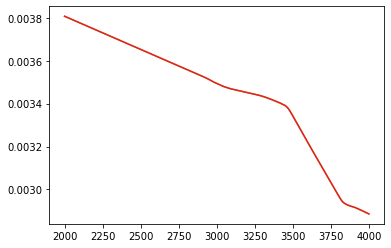

In [724]:
plt.plot(filament_state[-1][-1])
plt.plot(range(2000,4000),filament_state_test[0][0])

plt.plot(filament_state[-1][-1])
plt.plot(range(2000,4000),filament_state_test[0][1])


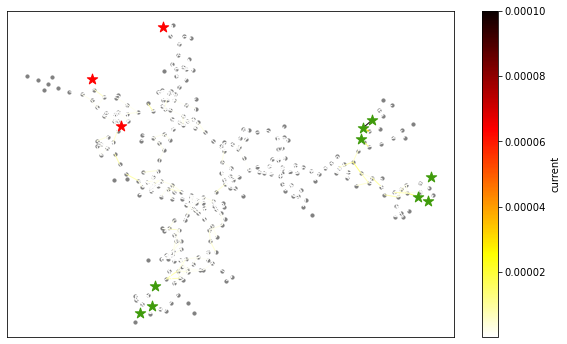

In [725]:
draw_network_state(connectivity,network_state_test[0][0])

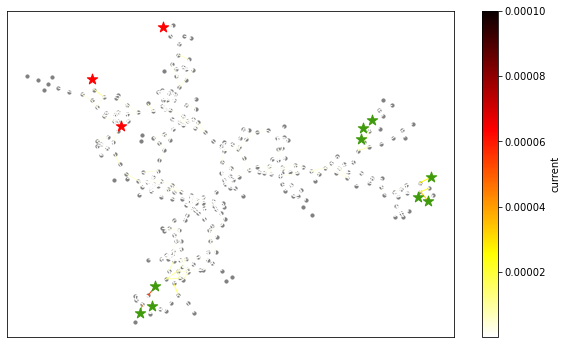

In [726]:
draw_network_state(connectivity,network_state_test[2][0])

In [727]:
zcost=np.sum(cost[0],axis=1)

In [728]:
vcost=np.sum(cost[1],axis=1)

In [729]:
ncost=np.sum(cost[2],axis=1)

In [730]:
df=pd.DataFrame([['z',zcost[0],zcost[1]],['v',vcost[0],vcost[1]],['n',ncost[0],ncost[1]]],columns=['Class','Test Sample 1','Test Sample 2'])

<AxesSubplot:xlabel='Class', ylabel='cost'>

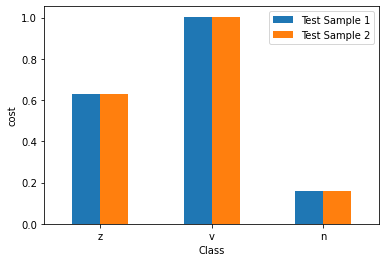

In [731]:
df.plot(x='Class', kind='bar', stacked=False,ylabel='cost',rot=0)

### old code

In [ ]:
# #Global Variables
# outputs={'cost':[],'current':[],'normcurrent':[],'state':[],'target':[]}
# count=0
# for target_index in tqdm(targets):
#     currInput=inputs[count][:-1]
#     target_index=int(target_index)
    
#     epochs=35 #number of 'training' to run
#     onAmp_init = 1 #amplitude for init
#     init_runTime=5 #duration of init signal
#     run_time = 1 # time for each iteration
#     dt = 0.001 #timesteps
#     numinit = 1 #number of times we initialise network pathways
#     signalType='DC' #Pulse, DC, AC, Square, Sawtooth

#     num_drain_init = 1 #number of drains for init simulation
#     num_source_init = len(sources) #number of sources

#     numtraining = 1 #number of training iterations per epoch
#     num_drain_training = 3 #total number of drain electrodes
#     num_source_training = len(sources) #total number of source electrodes
#     training_stimulus = []

#     #Run inital associative learning (akin to letting the network get to equilibrium)
#     sim1_stimulus=init(sources,onAmp_init,init_runTime,currInput,signalType)

#     #Save network state after this
#     sim1,JS0=getInitState(sim1_stimulus,sources,drain_pool,target_index,count)

#     #Set up the first instance of the training stimulus
#     sim2_stimulus=setupStimulus(training_stimulus,currInput,onAmp_init,signalType)

#     drainI=np.zeros((epochs,num_drain_training))
#     t=np.zeros((epochs,num_drain_training))
#     cost=np.zeros((epochs,num_drain_training)) 
#     print('---------- ')
#     print('Training Sample #'+str(count+1))
#     print('Target ' +str(target_index))
#     for i in range(epochs): #for each epoch
# #     i=0
# #     thisCostSum=1
# #     while thisCostSum>0.1: #repeat until cost is less than 0.1
#         print('Epoch ' + str(i))
#         #run training + change voltages - save network state after each epoch.
#         t[i],r,network_state,sim2=runSimulations(sim2_stimulus,JS0,signalType)
#         #normalised currents:
#         normT=(t[i]-np.mean(t[i]))/np.std(t[i])
# #         set_trace()
#         #define threshold (+- 3 orders of magnitude):
#         if i ==0:
#             #normalised thresholds:
#             th  =  1 #t[2]/ThresholdOrderMagnitudes #target threshold 
#             th2 = -1 #np.mean(t[0:2])*ThresholdOrderMagnitudes #non-target threshold 
#         #calculate output currents of drains after each epoch
#         #change the voltages of target and non-target drains to tune the network into using different pathways
#         drainI[i,:],sim2_stimulus,cost[i,:]=runAssLearning2(sim2_stimulus,sim2,normT,r,target_index,th,th2,signalType,)    
# #         thisCostSum=np.sum(cost[i,:])
# #         i+=1
        
#     outputs['current'].append(t)
#     outputs['normcurrent'].append(drainI)
#     outputs['cost'].append(cost)
#     outputs['target'].append(target_index)
#     outputs['state'].append(network_state)
#     count+=1

In [ ]:
# #Global Variables
# outputs          = {'cost':[],'current':[],'normcurrent':[],'randseed':[],'state':[],'target':[]}
# # count            = 0
# numSamples       = 100 #number of random samples from same class
# seed             = 42 #random seed
# epochs       = 10 #number of 'training' to run max, unless we hit 0.1 first
# thisNwState      = None #inital network state
# network_state    = [[[None] for i in range(epochs)] for i in range(numSamples)]

# np.random.seed(seed)

# for sample in tqdm(range(numSamples)): #run 100 random samples from the same class in random order
    
#     target_index = targets[targetClass] #set target class
#     val          = np.random.randint(len(trainingInputs)) #choose a random training sample
#     currInput    = trainingInputs[val][:-1] #define the input of that training sample
# #     currInput    = inputs[val][:-1]
#     target_index = int(target_index)
    
#     print('---------- ')
#     print('Training #'+str(sample+1))
#     print('Training Sample Chosen: '+str(val))
#     print('Class ' +str(target_letters[target_index]))
    
#     onAmp        = 1 #amplitude for init
# #     init_runTime = 5 #duration of init signal
#     run_time     = 2 # time for each iteration
#     dt           = 0.001 #timesteps
# #     numinit = 1 #number of times we initialise network pathways
#     signalType   ='DC' #Pulse, DC, AC, Square, Sawtooth

# #     num_drain_init = 1 #number of drains for init simulation
# #     num_source_init = len(sources) #number of sources
#     #Set up the first instance of the training stimulus
#     numtraining         = 1 #number of training iterations per epoch
#     num_drain_training  = 3 #total number of drain electrodes
#     num_source_training = len(sources) #total number of source electrodes
#     training_stimulus   = []
#     if sample == 0: #initalise drain stimulus only for first run, after that we use the stimulus from previous samples
#         print('No Inital Stimulus, Saving New Stimulus')
#     else:
#         training_drain_stimulus    = sim2_stimulus[:3] #save previous drains
#         training_stimulus          = setupSourcesOnly(training_drain_stimulus,currInput,onAmp,signalType) #setup new sources
#     print('Source Voltages '+str(currInput))
#     print('---------- ')
# #     #Run inital associative learning (akin to letting the network get to equilibrium)
# #     sim1_stimulus=init(sources,onAmp_init,init_runTime,currInput,signalType)

# #     #Save network state after this
# #     sim1,JS0=getInitState(sim1_stimulus,sources,drain_pool,target_index,count)

#     drainI        = np.zeros((epochs,num_drain_training))
#     t             = np.zeros((epochs,num_drain_training))
#     cost          = np.zeros((epochs,num_drain_training)) 
    
#     for i in range(epochs): #for each epoch

#         print('Epoch ' + str(i))

#         if sample == 0 and i == 0: #if we start the first sample and first epoch
#             print('No Inital Network State, Saving New State')
#         elif sample > 0 and i==0: #if we move to a new sample that isn't the first sample
#             thisNwState = network_state[sample-1][-1] #previous state from previous sample
#         elif sample >= 0 and i > 0: #if we move to a new epoch in the current sample
#             thisNwState = network_state[sample][i-1] #previous state from previous epoch 
#             #need to save for each epoch as well
#             #currently starting at same initial state, different voltages, but we want to save the state
#         #run training + change voltages - save network state after each epoch.

#         t[i],r,network_state[sample][i],sim2 = runSimulations(sim2_stimulus,thisNwState,signalType)
        
#         print('Currents '+str(t[i]))
#         print('Drain Voltages '+str(sim2.wireVoltage.T[drain_pool].T[0]))

#         #normalise currents:
#         normT = (t[i]-np.min(t[i]))/(np.max(t[i])-np.min(t[i]))#np.mean(t[i]))/np.std(t[i])
        
#         if i ==0:
#             #normalise thresholds:
#             th  = 1 #target threshold range + 0.2
#             th2 = 0 #non-target threshold range + 0.2
            
#         #calculate output currents of drains after each epoch
#         #change the voltages of target and non-target drains to tune the network into using different pathways
#         drainI[i,:],sim2_stimulus,cost[i,:] = runAssLearning2(sim2_stimulus,sim2,normT,r,target_index,th,th2,signalType)    
        
#         #if total cost is less than 0.02, end epochs for training sample
#         thisCostSum = np.sum(cost[i,:])
#         if thisCostSum < 0.02:
#             break;
    
#     outputs['current'].append(t)
#     outputs['normcurrent'].append(drainI)
#     outputs['cost'].append(cost)
#     outputs['target'].append(target_index)
#     outputs['state'].append(network_state[sample])
#     outputs['randseed']=seed
# #     count+=1

#     #if total cost is less than 0.02, end training samples
#     if thisCostSum < 0.02:
#         print('Global Minima Found')
#         break;